In [101]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from einops import rearrange

In [3]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from jax.config import config
config.update("jax_enable_x64", True)

In [5]:
import sys
sys.path.append("../")
from lensing_sim.lensing import LensingSim

In [122]:
cmap = 'coolwarm'

## Observational parameters

In [123]:
# Don't worry about these
exposure = 1610.0
n_xy = 96
pixel_size = 0.1
mag_zero=25.5
mag_iso=310.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

## MNIST download

In [124]:
from urllib import request
import gzip
import pickle

filename = [
["training_images","../data/train-images-idx3-ubyte.gz"],
["test_images","../data/t10k-images-idx3-ubyte.gz"],
["training_labels","../data/train-labels-idx1-ubyte.gz"],
["test_labels","../data/t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("../data/mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("../data/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# download_mnist()
# save_mnist()

mnist_sq = rearrange(load()[0], 'b (h w) -> b h w', h=28)

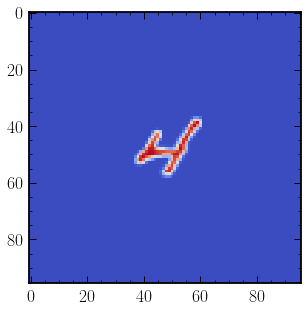

In [125]:
from skimage.transform import rescale, resize, downscale_local_mean

idx_image = np.random.randint(1000)
mnist_resized = resize(np.pad(mnist_sq[idx_image], (28, 28)), (n_xy, n_xy),
                       anti_aliasing=True)

plt.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)

## Real galaxies 

In [126]:
import galsim

In [380]:
from scipy.special import expit

In [431]:
ind = np.random.randint(2000)  # 4156

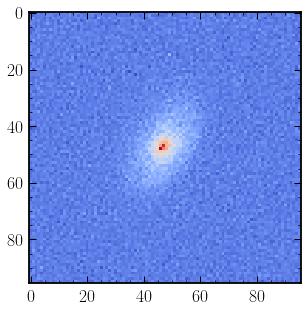

In [432]:
im_size = 96
pix_scale = 0.1 * 64 / im_size

bp_file = os.path.join(galsim.meta_data.share_dir, 'wfc_F814W.dat.gz')
bandpass = galsim.Bandpass(bp_file, wave_type='ang').thin().withZeropoint(25.94)

psf = galsim.OpticalPSF(diam=2.4, lam=1000.) # bigger than HST F814W PSF.

cosmos_cat = galsim.COSMOSCatalog(sample='23.5', dir='/n/holyscratch01/dvorkin_lab/smsharma/COSMOS_23.5_training_sample/')

im = cosmos_cat.makeGalaxy(ind, gal_type='real', noise_pad_size=im_size * pix_scale)

real_gal = galsim.Convolve(im, psf)
im_real = galsim.Image(im_size, im_size)
im_real = real_gal.drawImage(image=im_real, scale=pix_scale)

im_source = im_real.array  #  nn.sigmoid(im_real.array)

plt.imshow(im_source, cmap=cmap)

In [433]:
# # Lensed image

# lens_list = [hst_param_dict]
        
# lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
# image = lsi.lensed_image()

# plt.imshow(image)

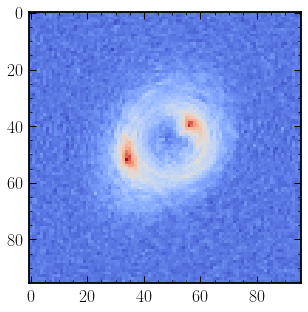

In [434]:
# Change the lens position

src_param_dict = {"profile": "CartesianGrid", "src_ary": im_source} 
hst_param_dict = {"profile": "SIE", "theta_x_0": -0.3, "theta_y_0": 0.4, "theta_E": 1.5, "q": 0.7}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image() 
image += 0.2 * np.random.randn(*image.shape)

plt.imshow(image.T, cmap=cmap)

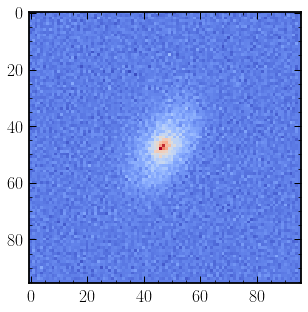

In [435]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = jnp.nan_to_num(lsi.lensed_image())

plt.imshow(image_nolens.T, cmap=cmap)

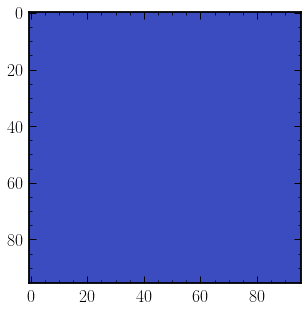

In [436]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc, cmap=cmap)

In [437]:
np.mean(image_nolens - image_nosrc), np.std(image_nolens - image_nosrc)

(DeviceArray(0.18481136, dtype=float64),
 DeviceArray(0.81969481, dtype=float64))

In [438]:
np.mean(mnist_resized), np.std(mnist_resized)

(0.012240520801419522, 0.09394758927831588)

## Custom source

In [439]:
import sys
sys.path.append("../")

from lensing_sim.profiles import LightProfileSersic

In [440]:
from jax import vmap, jit
from einops import rearrange, repeat

In [441]:
# Lensed image

def render_lens(inputs):
    lens_list = [hst_param_dict]
    src_param_dict = {"profile": "CartesianGrid", "src_ary": inputs}    

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [442]:
theta_x_lims = theta_y_lims = [-1.5, 1.5]
n_x = n_y = 64

theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [443]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [444]:
def positional_encoding(inputs, positional_encoding_dims=8):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [445]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [447]:
num_dense_layers = 8
dense_layer_width = 256
add_positional_encoding = True
add_skip_connection = True

In [448]:
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        for i in range(num_dense_layers):
            # Apply positional encoding to the input points
            
            if add_positional_encoding:
                x = positional_encoding(input_points)
            else:
                x = input_points
                                    
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            
            if add_skip_connection:
                # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x

        x = nn.Dense(2, dtype=self.dtype)(x)
        return x


In [449]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [450]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(43))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

In [451]:
# input_to_network = jnp.ones((1, 2 * n_xy * n_xy))
input_to_network = jnp.ones((n_xy * n_xy, 2))

In [452]:
model.apply({"params": params}, input_to_network).shape

(9216, 2)

In [453]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 72194 parameters'

In [454]:
theta_x_lims = theta_y_lims = [-1., 1.]
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)
# image_input =  jax.scipy.special.logit(nn.sigmoid(jnp.expand_dims(image, 0)))

image_input

DeviceArray([[[ 0.42130973, -0.66193439,  0.50948413, ...,  0.23788395,
                0.43563344, -0.23499727],
              [ 0.70375053,  0.02474684,  0.31179718, ..., -0.13415842,
                0.11633501,  0.15983474],
              [ 0.18648943,  0.03687157, -0.40779301, ...,  0.3563801 ,
                0.10223642,  0.161573  ],
              ...,
              [ 0.41239775, -0.42977798,  0.27923432, ..., -0.43786664,
                0.15539045, -0.37105267],
              [ 0.05667345, -0.65677325, -0.17280362, ...,  0.28287926,
                0.21099337, -0.34916419],
              [ 0.33845577, -0.31863595,  0.12521826, ...,  0.20689568,
                0.07376695, -0.32355939]]], dtype=float64)

In [455]:
# model_fn = lambda x: model.apply({"params": params}, x)
# # model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
# model_output = rearrange(model_output, "(h w) 1 -> 1 h w", h=n_xy, w=n_xy)

# lenses = render_lens_vmapped(model_output)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

# epoch = -1

# ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
# ax1.set_title(f"Predicted source at epoch {epoch}")
# ax1.axis("off")
# ax2.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)
# ax2.set_title(f"True source")
# ax2.axis("off")
# ax3.imshow(lenses[0].T, cmap=cmap)
# ax3.set_title(f"Predicted lensed image at epoch {epoch}")
# ax3.axis("off")
# ax4.imshow(image_input[0].T, cmap=cmap)
# ax4.set_title(f"True lensed image")
# ax4.axis("off")
# plt.show()

In [458]:
n_q_samples = 64

In [459]:
import distrax

In [460]:
def train_step(state, batch, key):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output = model_fn(inputs)
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy, w=n_xy)
        
        mu = model_output[0]
        sigma = jnp.sqrt(jnp.exp(model_output[1]))
        
        dist_distrax = distrax.Normal(mu, sigma)
        
        samples, loss_q = dist_distrax.sample_and_log_prob(seed=key, sample_shape=(n_q_samples,))
        loss_q = jnp.mean(loss_q)
                
        samples = rearrange(samples, "s (h w) -> s h w", h=n_xy, w=n_xy)

        lenses = render_lens_vmapped(samples)
                
        # Compute mean-squared error
        loss_mse = jnp.mean((lenses - targets) ** 2) 
        
        return loss_mse + loss_q
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state 

In [461]:
learning_rate = 8e-4
weight_decay = 1e-5
momentum = 0.8
optimizer_name = "adamw"

In [462]:
train_epochs = 2000

In [463]:
coords.shape, image_input.shape

((2, 96, 96), (1, 96, 96))

In [464]:
from celluloid import Camera
show_maps = True

# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(43))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum, nesterov=True)
else:
    raise NotImplementedError
    
# Create the Training State
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)


# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn):
        
    train_loss_history, train_psnr_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], [], []
    
    key, rng = jax.random.split(jax.random.PRNGKey(42))
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, train_psnr, state = train_step_fn(state, train_batch, key)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % 50 == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy, w=n_xy)
                        
            lenses = render_lens_vmapped(model_output)
            
            reconstructed_lens_history.append(np.asarray(lenses[0].T))
            reconstructed_src_mu_history.append(np.asarray(model_output[0]))
            reconstructed_src_std_history.append(np.asarray(model_output[1]))
            
            if show_maps:
                
                print(np.asarray(np.mean(train_loss)))
                
                fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

                ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
                ax1.set_title(f"Predicted source at epoch {epoch}")
                ax1.axis("off")
                ax2.imshow(im_source, cmap=cmap, vmin=0, vmax=1)
                ax2.set_title(f"True source")
                ax2.axis("off")
                ax3.imshow(lenses[0].T, cmap=cmap)
                ax3.set_title(f"Predicted lensed image at epoch {epoch}")
                ax3.axis("off")
                ax4.imshow(image_input[0].T, cmap=cmap)
                ax4.set_title(f"True lensed image")
                ax4.axis("off")
                im = ax5.imshow((lenses[0].T - image_input[0].T), cmap=cmap)
                ax5.set_title(f"Residual")
                ax5.axis("off")
                cbar = fig.colorbar(im, ax=ax5, extend='both')
                plt.show()
    
    hist = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history
    }
    
    return state, hist

  0%|          | 0/2000 [00:00<?, ?it/s]

215.82277593275012


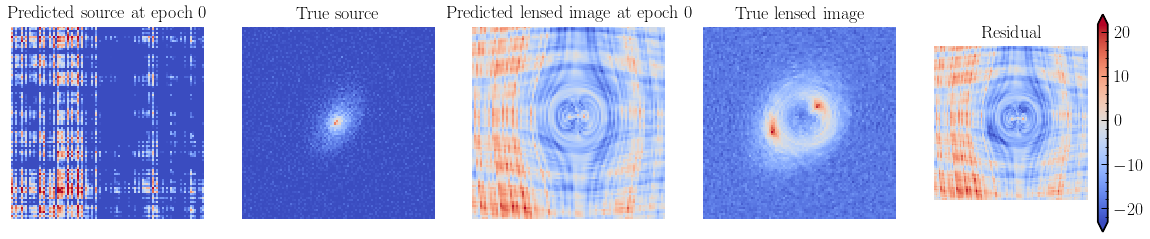

  2%|▎         | 50/2000 [00:17<07:07,  4.56it/s] 

12.346747332957914


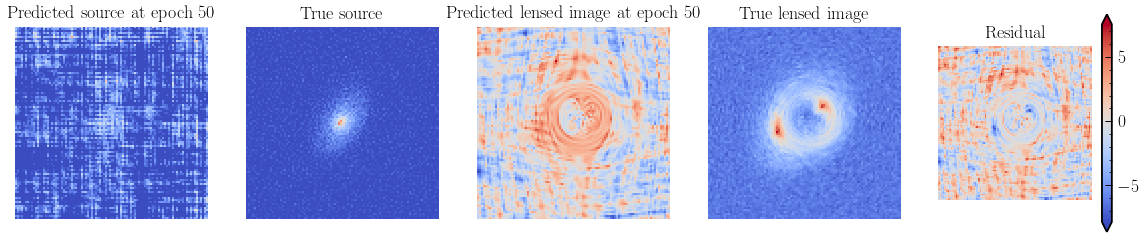

  5%|▌         | 100/2000 [00:29<06:52,  4.60it/s]

5.791722769592491


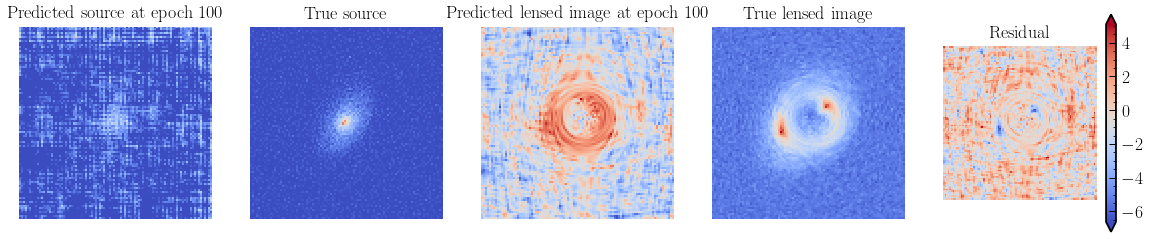

  8%|▊         | 150/2000 [00:40<06:42,  4.59it/s]

3.8319932437938666


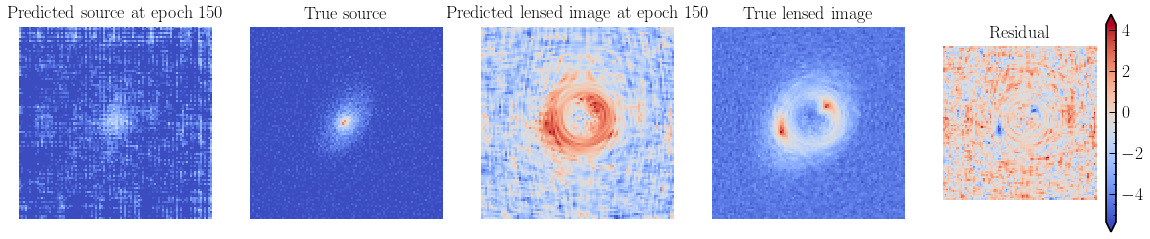

 10%|█         | 200/2000 [00:52<06:27,  4.65it/s]

3.0332203563538602


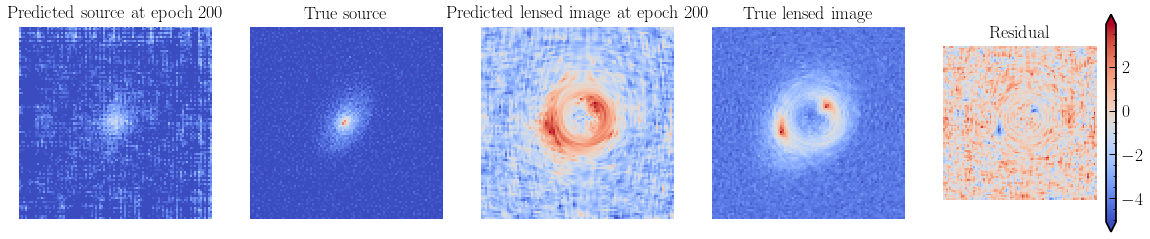

 12%|█▎        | 250/2000 [01:04<06:21,  4.59it/s]

2.6395555959119488


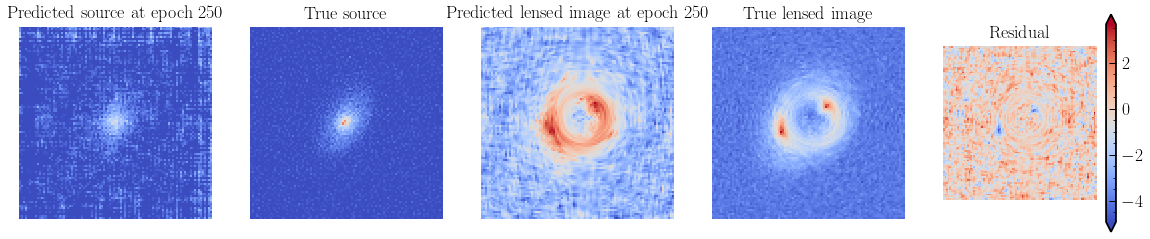

 15%|█▌        | 300/2000 [01:15<06:10,  4.59it/s]

2.4133064243173994


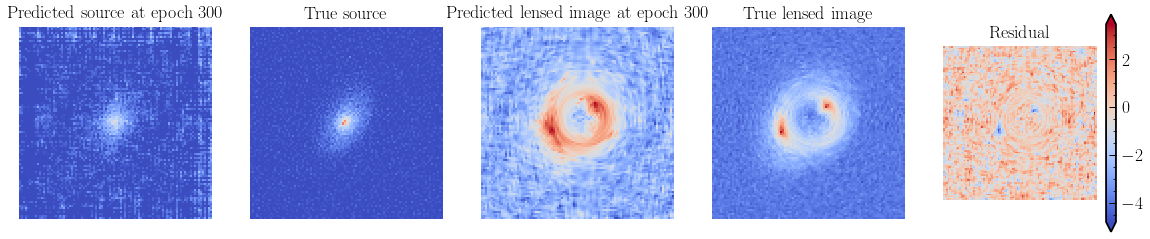

 18%|█▊        | 350/2000 [01:27<05:56,  4.62it/s]

2.290473120715583


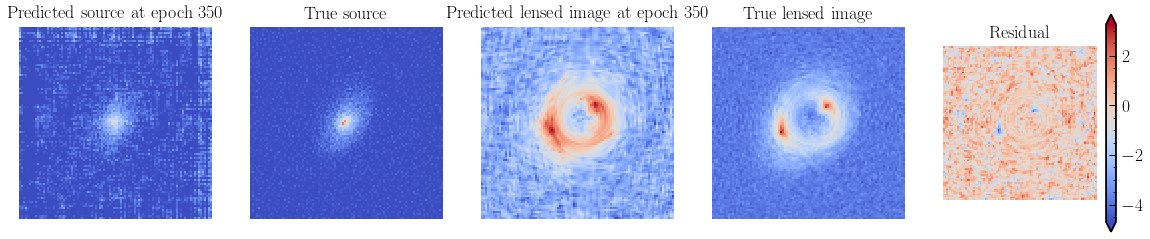

 20%|██        | 400/2000 [01:39<05:49,  4.58it/s]

2.1993176067214737


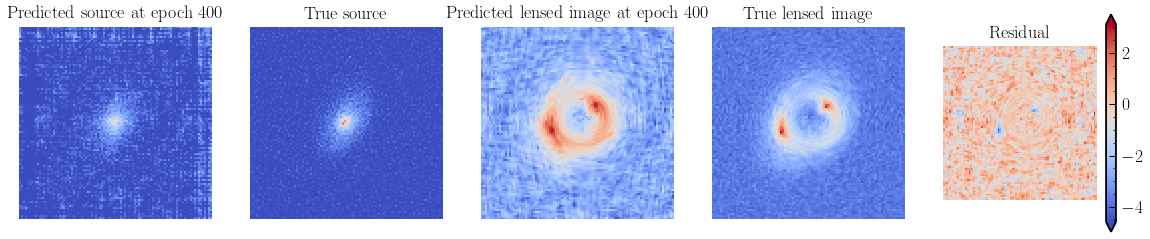

 22%|██▎       | 450/2000 [01:50<05:40,  4.55it/s]

2.1308546505851442


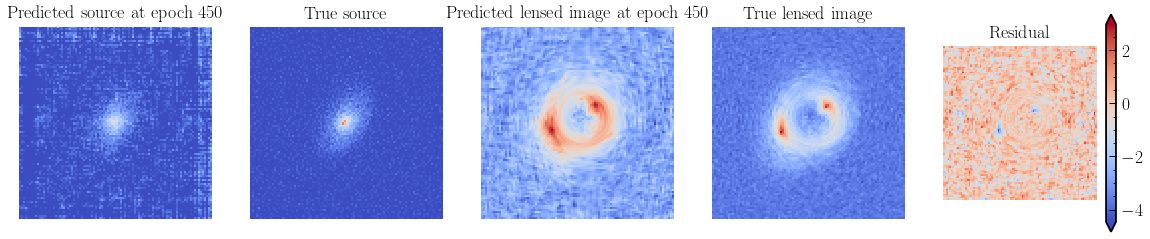

 25%|██▌       | 500/2000 [02:02<05:27,  4.59it/s]

2.0808748064514786


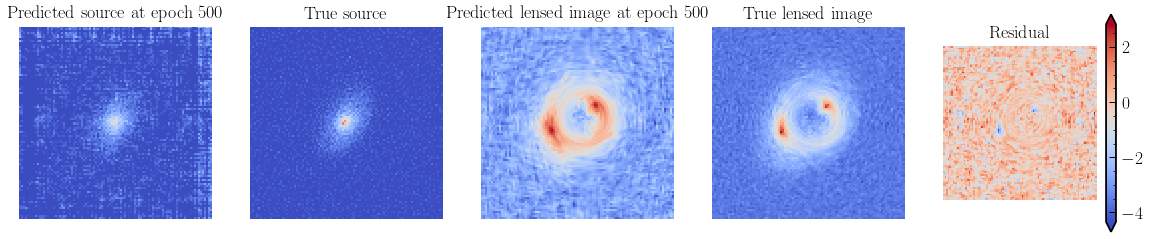

 28%|██▊       | 550/2000 [02:14<05:21,  4.51it/s]

2.0340967647883095


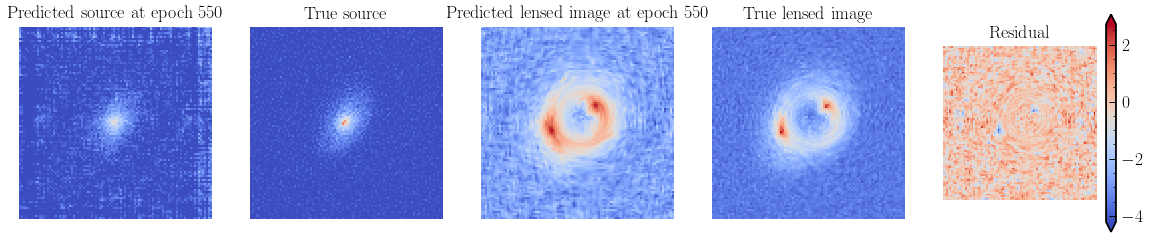

 30%|███       | 600/2000 [02:25<05:05,  4.59it/s]

1.9999983339557013


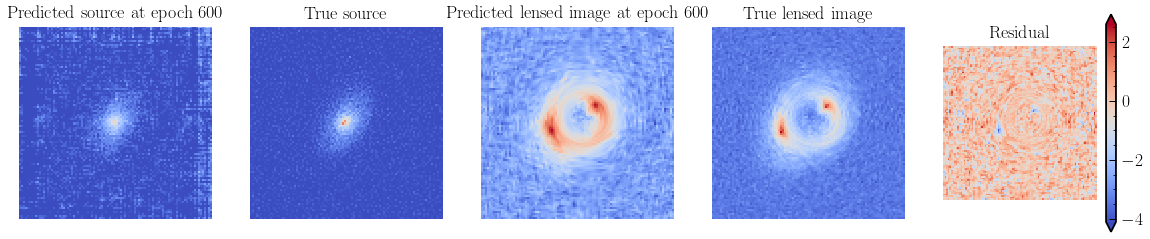

 32%|███▎      | 650/2000 [02:37<04:53,  4.60it/s]

1.9665072620710702


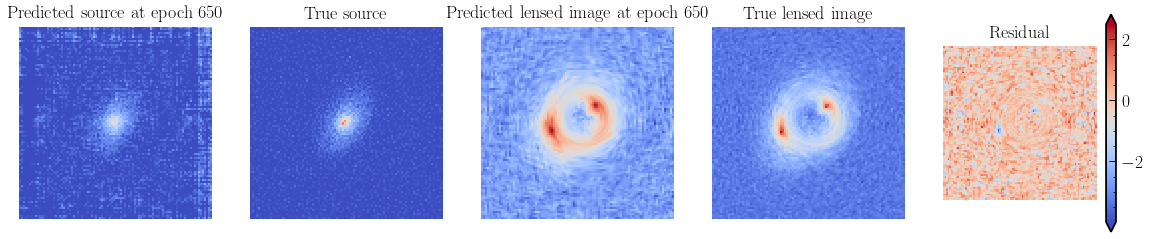

 35%|███▌      | 700/2000 [02:48<04:37,  4.69it/s]

1.9367830737525524


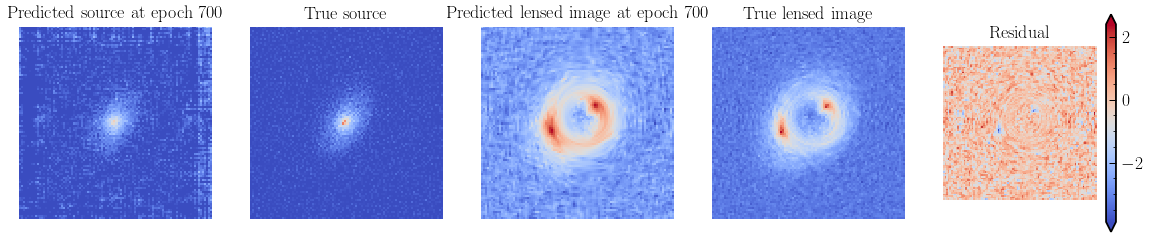

 38%|███▊      | 750/2000 [03:00<04:31,  4.60it/s]

1.9119372442917726


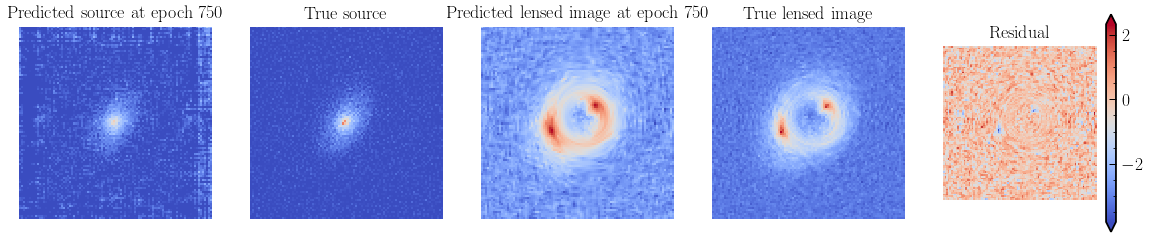

 40%|████      | 800/2000 [03:12<04:21,  4.58it/s]

1.8924718360219654


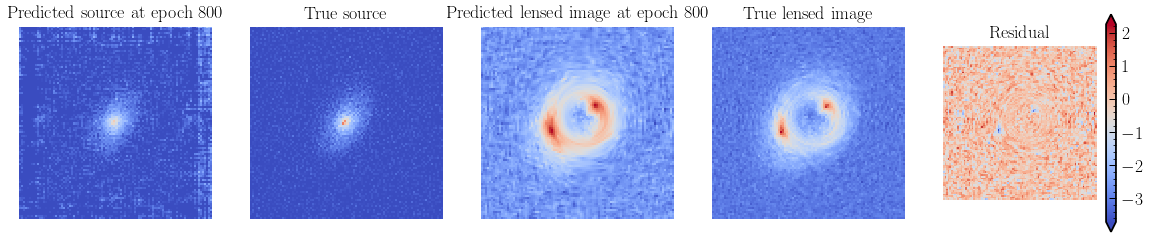

 42%|████▎     | 850/2000 [03:23<04:09,  4.61it/s]

1.8678892733407726


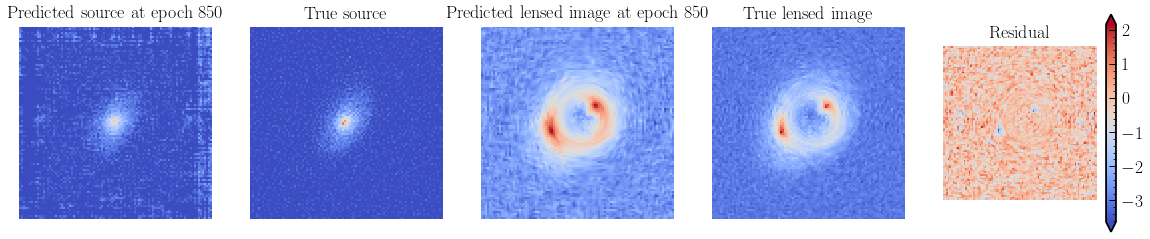

 45%|████▌     | 900/2000 [03:35<04:01,  4.55it/s]

1.8506849076395728


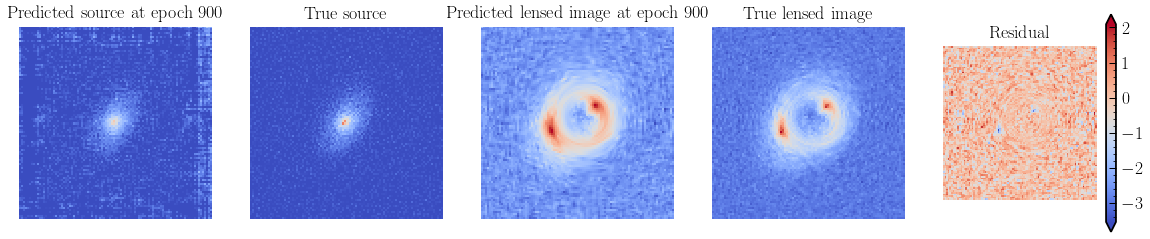

 48%|████▊     | 950/2000 [03:47<03:48,  4.60it/s]

1.8300351852905477


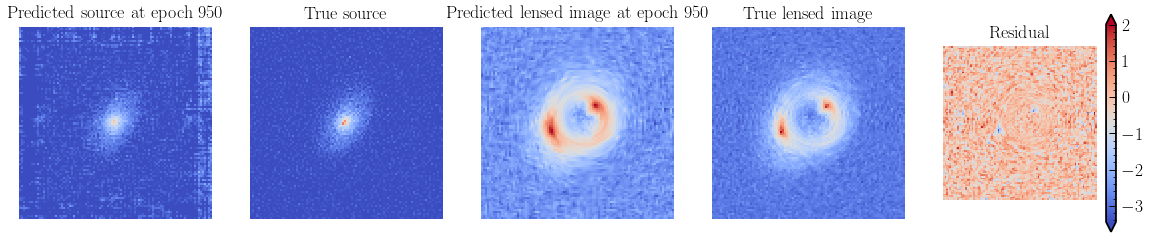

 50%|█████     | 1000/2000 [03:58<03:37,  4.60it/s]

1.8093056077683594


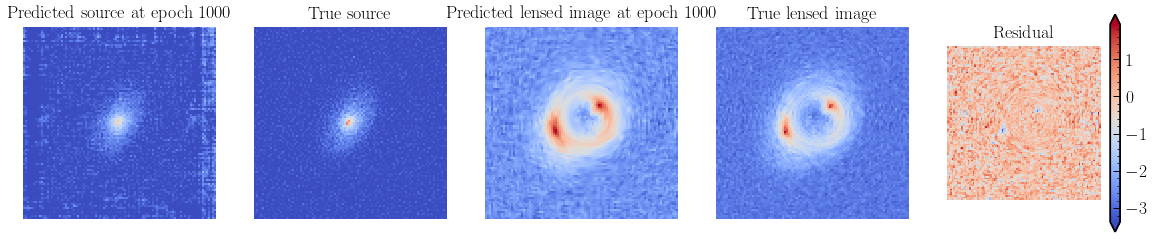

 52%|█████▎    | 1050/2000 [04:10<03:25,  4.62it/s]

1.7946305322383238


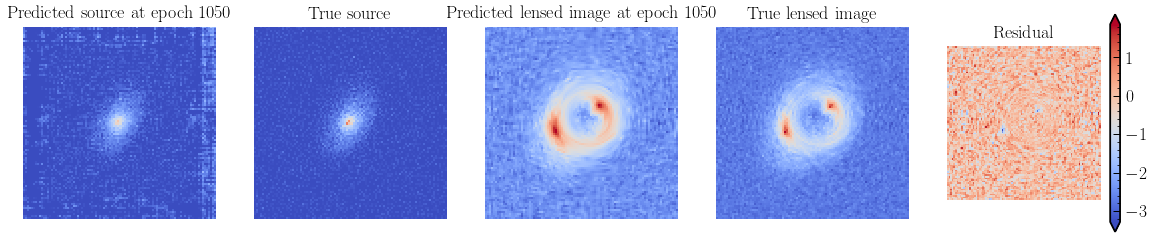

 55%|█████▌    | 1100/2000 [04:22<03:17,  4.55it/s]

1.7796212382915404


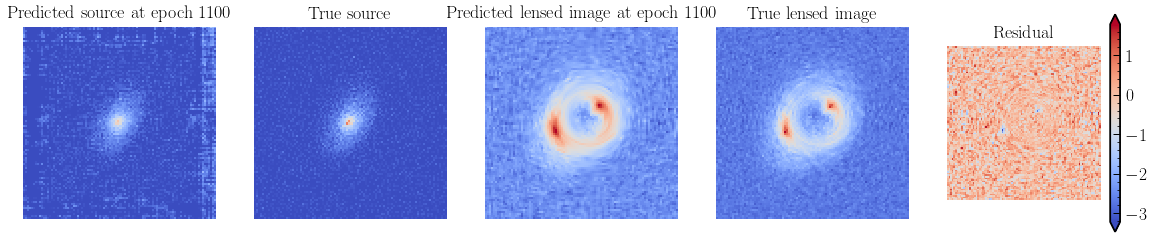

 57%|█████▊    | 1150/2000 [04:34<03:21,  4.23it/s]

1.7633654410558348


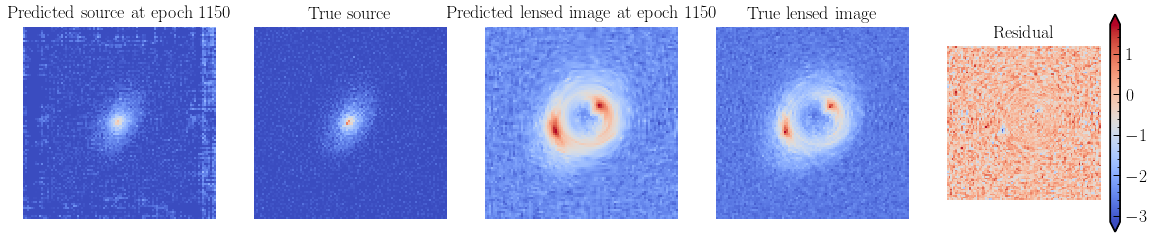

 60%|██████    | 1200/2000 [04:48<03:06,  4.30it/s]

1.7495249295156712


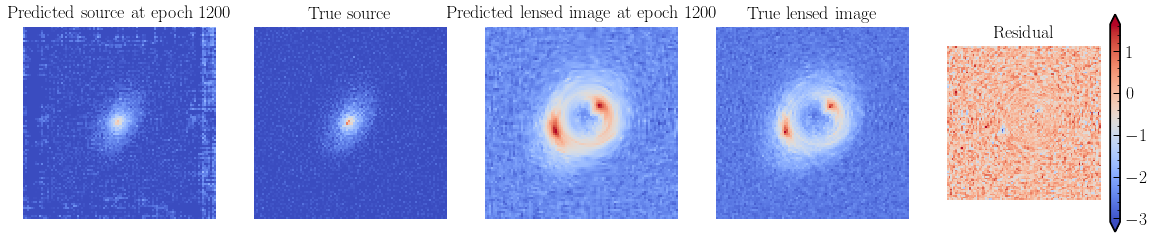

 62%|██████▎   | 1250/2000 [05:01<02:56,  4.25it/s]

1.7337764727556668


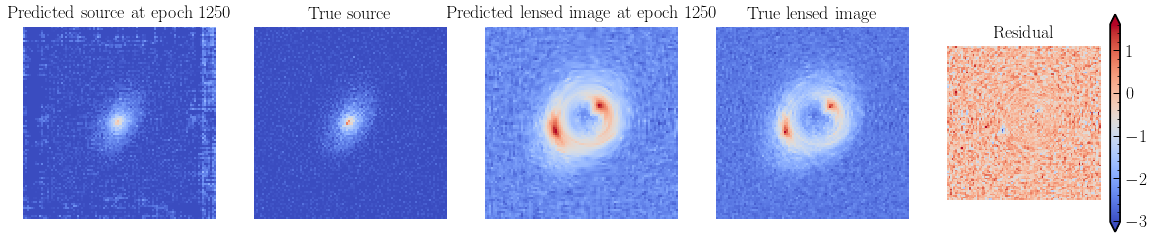

 65%|██████▌   | 1300/2000 [05:15<02:44,  4.25it/s]

1.7218812697785062


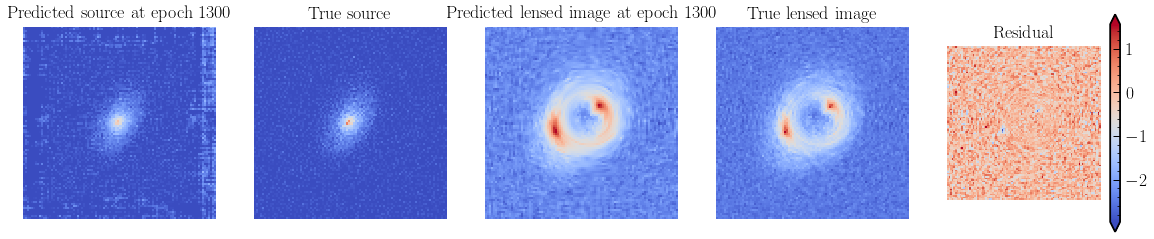

 68%|██████▊   | 1350/2000 [05:28<02:35,  4.19it/s]

1.708303503740562


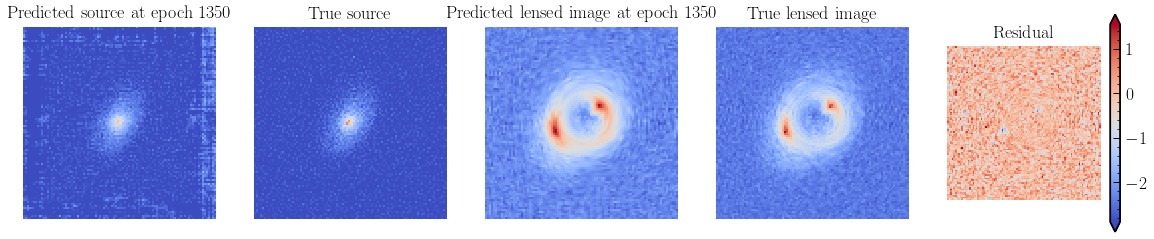

 70%|███████   | 1400/2000 [05:41<02:21,  4.25it/s]

1.6943719939666049


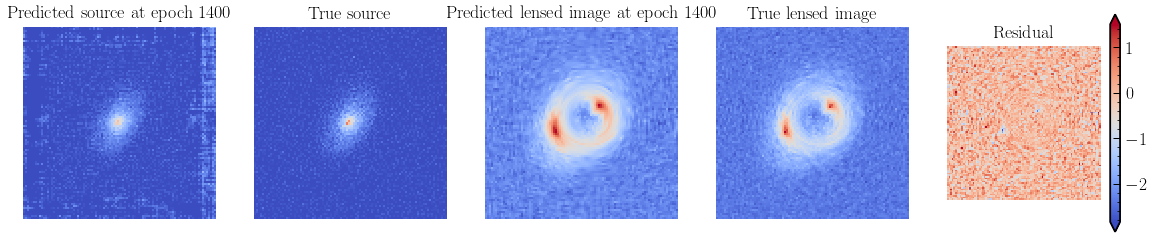

 72%|███████▎  | 1450/2000 [05:55<03:18,  2.78it/s]

1.6850983108884998


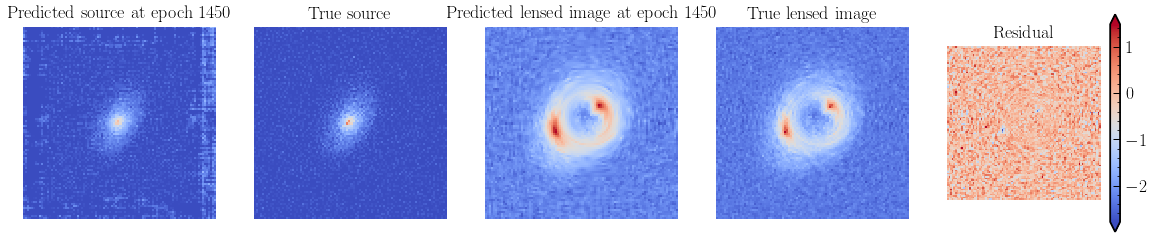

 75%|███████▌  | 1500/2000 [06:08<01:59,  4.18it/s]

1.6722531306498793


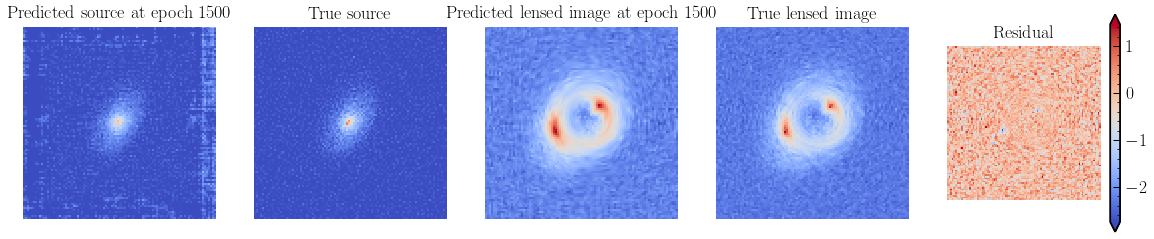

 78%|███████▊  | 1550/2000 [06:22<01:45,  4.28it/s]

1.6579177532674159


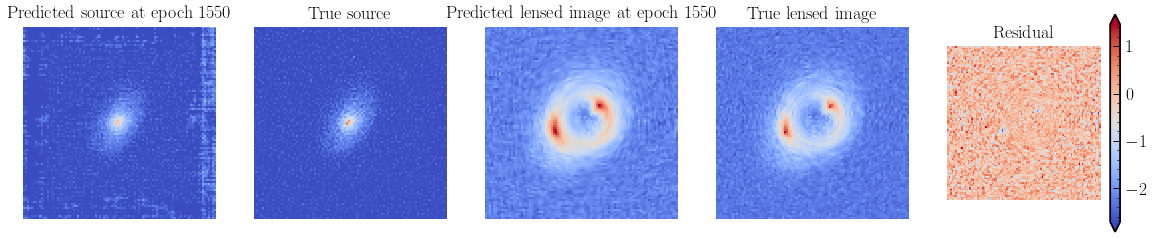

 80%|████████  | 1600/2000 [06:35<01:35,  4.17it/s]

1.6439155564955765


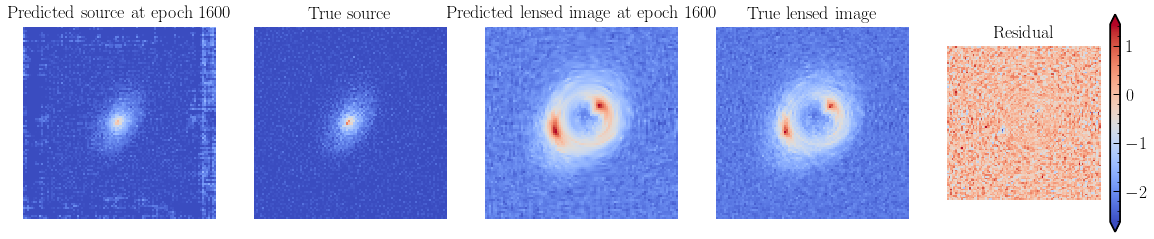

 82%|████████▎ | 1650/2000 [06:49<01:25,  4.11it/s]

1.6296980032030315


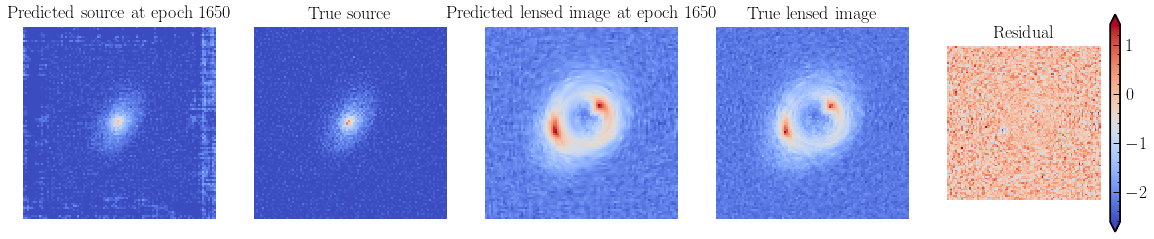

 85%|████████▌ | 1700/2000 [07:02<01:10,  4.25it/s]

1.6177221310141223


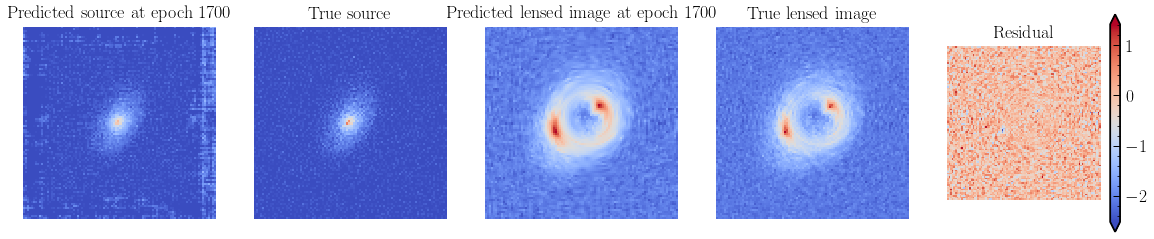

 88%|████████▊ | 1750/2000 [07:16<01:00,  4.15it/s]

1.6045033480166406


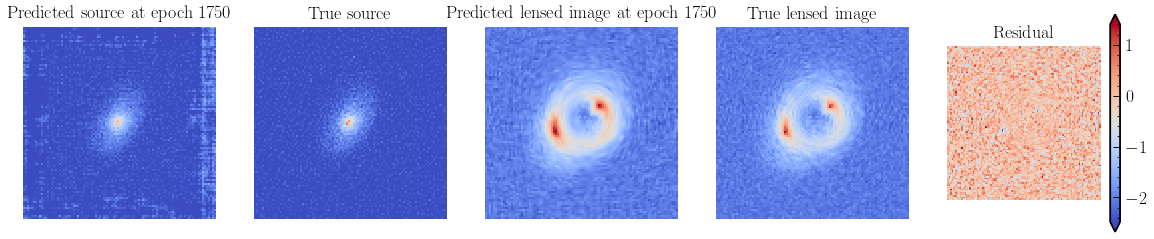

 90%|█████████ | 1800/2000 [07:29<00:47,  4.20it/s]

1.5923498759904868


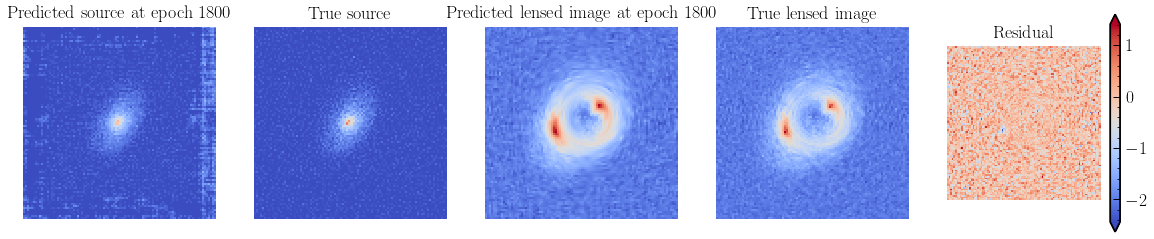

 92%|█████████▎| 1850/2000 [07:43<00:35,  4.25it/s]

1.576446813922274


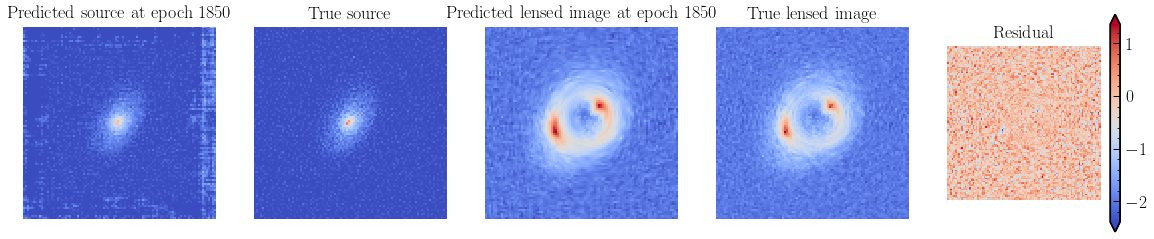

 95%|█████████▌| 1900/2000 [07:56<00:23,  4.22it/s]

1.56403498088663


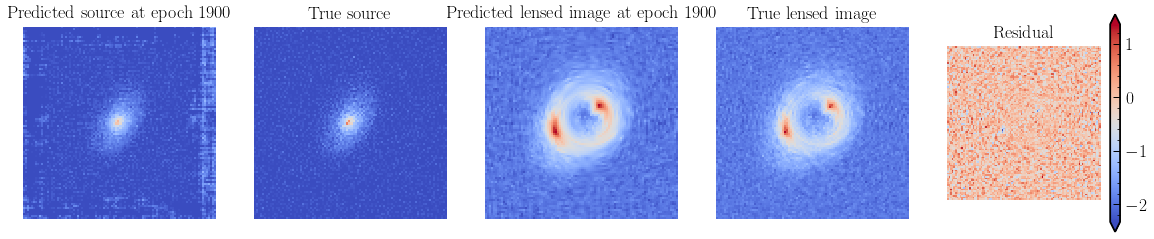

 98%|█████████▊| 1950/2000 [08:09<00:11,  4.27it/s]

1.549983254876497


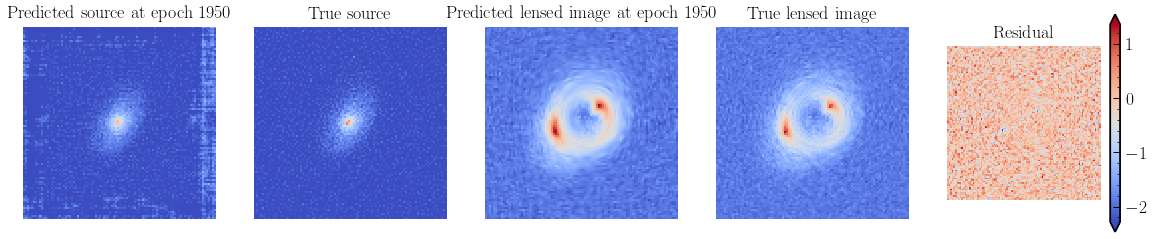

100%|██████████| 2000/2000 [08:23<00:00,  3.97it/s]


In [465]:
state, hist = train_and_evaluate(state, train_step)

In [466]:
# hist["reconstructed_src_mu"]

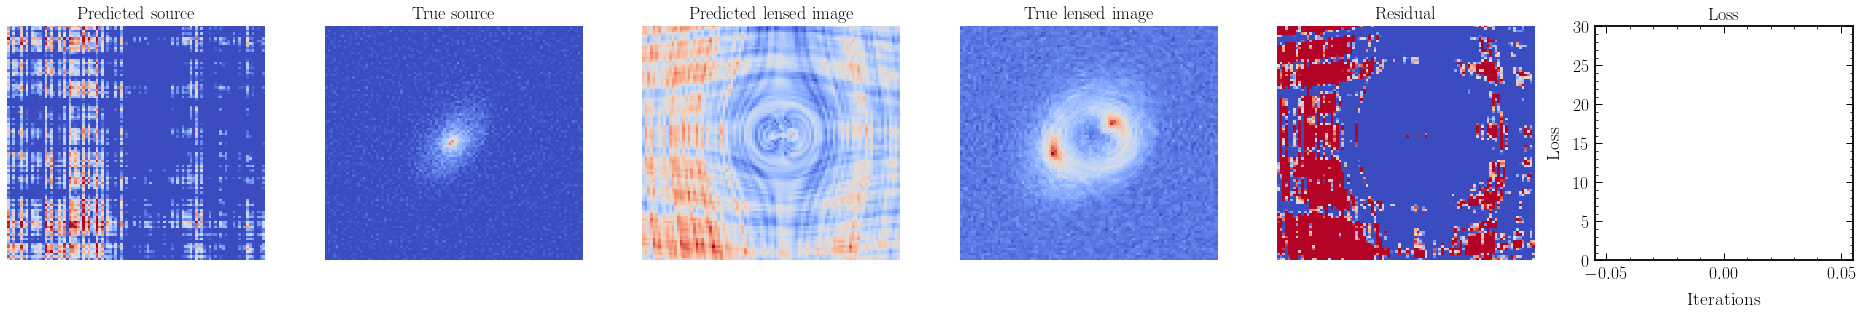

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [472]:
epoch = -1

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(26, 4.5))
camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):
    ax1.imshow(hist["reconstructed_src_mu"][i], cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax1.set_title(f"Predicted source")
    ax1.axis("off")
    ax2.imshow(im_source, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
    ax3.set_title(f"Predicted lensed image")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    # im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
    im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T), cmap=cmap, aspect="auto", vmin=-1.5, vmax=1.5)
    ax5.set_title(f"Residual")
    ax5.axis("off")
    ax6.plot(np.arange(50 * (i)), hist["train_loss"][:50 * (i)], color=cols_default[0])
    ax6.set_title(f"Loss")
    ax6.set_xlabel(f"Iterations")
    ax6.set_ylabel(f"Loss")
    ax6.set_ylim(0, 30.)
    # cbar = fig.colorbar(im, ax=ax5)
    plt.tight_layout()
    plt.show()
    camera.snap()

In [473]:
animation = camera.animate()
animation.save('render.gif', fps=8)

In [474]:
hist["train_loss"][-1]

array(1.53117553)

(0.0, 30.0)

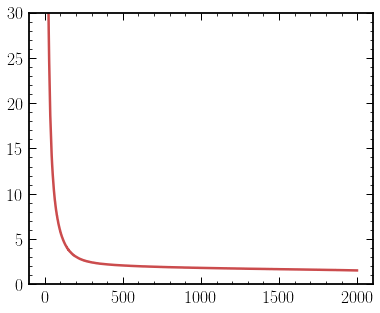

In [475]:
plt.plot(hist["train_loss"])
# plt.plot(hist["train_psnr"])
plt.ylim(0, 30)

In [128]:
# model_fn = lambda x: state.apply_fn({"params": state.params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
# plt.imshow(model_output[0])

## Flow experiments 

In [86]:
import distrax

key = jax.random.PRNGKey(1234)

mu = jnp.array([-1., 2.])
sigma = jnp.array([0.1, 0.2])

dist_distrax = distrax.Normal(mu, sigma)

samples = dist_distrax.sample(seed=key, sample_shape=(64,))

samples.shape

(64, 2)

In [87]:
dist_distrax.log_prob(samples).mean()

DeviceArray(0.51576647, dtype=float64)

In [107]:
class SimpleMLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f'layers_{i}')(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
                # providing a name is optional though!
                # the default autonames would be "Dense_0", "Dense_1", ...
        return x

key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.uniform(key1, (4,4))

model = SimpleMLP(features=[3,4,5])
params = model.init(key2, x)
y = model.apply(params, x)

In [108]:
y.shape

(4, 5)

In [112]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple


# def make_conditioner(event_shape: Sequence[int],
#                      hidden_sizes: Sequence[int],
#                      num_bijector_params: int) -> nn.Module:
#     """Creates an MLP conditioner for each layer of the flow."""
#     return hk.Sequential([
#       hk.Flatten(preserve_dims=-len(event_shape)),
#       hk.nets.MLP(hidden_sizes, activate_final=True),
#       # We initialize this linear layer to zero so that the flow is initialized
#       # to the identity function.
#       hk.Linear(
#           np.prod(event_shape) * num_bijector_params,
#           w_init=jnp.zeros,
#           b_init=jnp.zeros),
#       hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
#     ])

Array = jnp.ndarray

def make_flow_model(event_shape: Sequence[int],
                    num_layers: int,
                    hidden_sizes: Sequence[int],
                    num_bins: int) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = jnp.arange(0, np.prod(event_shape)) % 2
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.(
            params, range_min=0., range_max=1.)

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1
    
    conditioner = SimpleMLP(features=[64,64, event_shape[0] + num_bijector_params])
    
    x = jax.random.uniform(key, (3, 1))
    params = conditioner.init(key, x)
    conditioner_fn = lambda inputs: conditioner.apply(params, inputs)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            # conditioner=make_conditioner(event_shape, hidden_sizes, num_bijector_params))
            conditioner=conditioner_fn)
            
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
      distrax.Uniform(
          low=jnp.zeros(event_shape),
          high=jnp.ones(event_shape)),
      reinterpreted_batch_ndims=len(event_shape))

    return distrax.Transformed(base_distribution, flow)

flow_model = make_flow_model(event_shape=[1], num_layers=4, hidden_sizes=[64,64], num_bins=3)
flow_model.sample(seed=key)

ValueError: The last dimension of `params` must have size `3 * num_bins + 1` and `num_bins` must be at least 1. Got size 11.

In [84]:
# sys.path.append("../../jax-flows/")
# sys.path.append("../../")

# import flows

# num_blocks = 4

# modules = []
# for _ in range(num_blocks):
#     modules += [
#         flows.NeuralSplineCoupling(),
#     ]
    
# bijection = flows.Serial(*tuple(modules))
# prior = flows.Normal()

# init_fun = flows.Flow(bijection, prior)
# params, log_pdf, sample = init_fun(key, 2)

# inputs = jnp.ones((64, 2))
# # -log_pdf(params, inputs).mean()